In [1]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
import jax.numpy as jnp
import numpy as np

import equinox as eqx


In this example, we solve a lineear elasticity problem of a circular inclusion in a square matrix. The inclusion is a material with a different elastic properties than the matrix. We use the Fourier-Galerkin method to solve the problem.

We import the necessary modules and set up the environment. The module `spectralsolvers` contains the operators and solvers for the Fourier-Galerkin method. We import the `fourier_galerkin` module to create the Fourier-Galerkin operator, `spatial` module to create the spatial operators, `tensor` module to create the tensor operators, and `fft` module to create the FFT and IFFT operators. We import the `conjugate_gradient_while` and `newton_krylov_solver` modules to create the solvers.


In [2]:
from functools import partial

import matplotlib.pyplot as plt
from skimage.morphology import disk
from spectralsolver import (
    DifferentialMode,
    SpectralSpace,
    TensorOperator,
    make_field,
)
from spectralsolver.green_functions import fourier_galerkin

To simplify the execution of the code, we define a `ElasticityOperator` class that contains the Fourier-Galerkin operator, the spatial operators, the tensor operators, and the FFT and IFFT operators. The `__init__` method initializes the operator and the `__call__` method computes the stresses in the real space given as 

$$
\mathcal{F}^{-1} \left( \mathbb{G}:\mathcal{F}(\mathbf{\sigma}) \right) = \mathbf{0}
$$

We define the grid size and the length of the RVE and construct the structure of the RVE.

In [3]:
N = 199
shape = (N, N)
length = 1.0
ndim = 2


# @imshow(cmap=cmc.managua, enable=True)
def create_structure(N):
    Hmid = int(N / 2)
    Lmid = int(N / 2)
    r = int(N / 4)

    structure = np.ones((N, N))
    structure[Hmid - r : Hmid + r + 1, Lmid - r : Lmid + r + 1] -= disk(r)

    return structure


structure = create_structure(N)

In [4]:
tensor = TensorOperator(dim=ndim)
space = SpectralSpace(size=N, dim=ndim, length=length)
#op = SpectralOperator(space=space, diff_mode=DifferentialMode.rotated_difference)

Next, we define the material parameters.

In [5]:
# material parameters + function to convert to grid of scalars
def param(X, inclusion, solid):
    props = inclusion * jnp.ones_like(X) * (1 - X) + solid * jnp.ones_like(X) * (X)
    return props

In [6]:
# material parameters
phase_contrast = 1 / 1e3

# lames constant
lambda_modulus = {"solid": 1.0, "inclusion": phase_contrast}
shear_modulus = {"solid": 1.0, "inclusion": phase_contrast}

bulk_modulus = {}
bulk_modulus["solid"] = lambda_modulus["solid"] + 2 * shear_modulus["solid"] / 3
bulk_modulus["inclusion"] = (
    lambda_modulus["inclusion"] + 2 * shear_modulus["inclusion"] / 3
)

In [7]:
λ0 = param(
    structure, inclusion=lambda_modulus["inclusion"], solid=lambda_modulus["solid"]
)  # lame parameter
μ0 = param(
    structure, inclusion=shear_modulus["inclusion"], solid=shear_modulus["solid"]
)  # lame parameter
K0 = param(structure, inclusion=bulk_modulus["inclusion"], solid=bulk_modulus["solid"])

The linear elasticity strain energy is given as 

$$
W = \frac{1}{2} \int_{\Omega}  (\lambda \text{tr}(\epsilon)^2+ \mu \text{tr}(\epsilon : \epsilon ) ) d\Omega
$$

We define a python function to compute the strain energy and then use the `jax.jacrev` function to compute the stress tensor.

In [8]:
@eqx.filter_jit
def strain_energy(eps):
    eps_sym = 0.5 * (eps + tensor.trans(eps))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace(eps_sym) ** 2) + jnp.multiply(
        μ0, tensor.trace(tensor.dot(eps_sym, eps_sym))
    )
    return energy.sum()


#compute_stress = jax.jit(jax.jacrev(strain_energy))

I = make_field(dim=ndim, N=N, rank=2)
I[:, :, 0, 0] = 1
I[:, :, 1, 1] = 1


def compute_stress(eps):
    return jnp.einsum("..., ...ij->...ij", λ0 * tensor.trace(eps), I) + 2 * jnp.einsum(
        "..., ...ij->...ij", μ0, eps
    )


In [9]:
Ghat = fourier_galerkin.compute_projection_operator(
    space=space, diff_mode=DifferentialMode.rotated_difference
)

In [10]:
eps = make_field(dim=2, N=N, rank=2)

In [11]:
@eqx.filter_jit
def _tangent(deps, Ghat, dofs_shape):
    deps = deps.reshape(dofs_shape)
    dsigma = compute_stress(deps)
    return jnp.real(space.ifft(tensor.ddot(Ghat, space.fft(dsigma)))).reshape(-1)

@eqx.filter_jit
def _residual(deps, Ghat, dofs_shape):
    deps = deps.reshape(dofs_shape)
    sigma = compute_stress(deps)
    return jnp.real(space.ifft(tensor.ddot(Ghat, space.fft(sigma)))).reshape(-1)


residual = jax.jit(partial(_residual, Ghat=Ghat, dofs_shape=eps.shape))
jacobian = jax.jit(partial(_tangent, Ghat=Ghat, dofs_shape=eps.shape))

In [12]:
from spectralsolver.solvers.nonlinear import (
    conjugate_gradient_while,
    newton_krylov_solver,
)

In [13]:
applied_strains = jnp.diff(jnp.linspace(0, 2e-1, num=20))

deps = make_field(dim=2, N=N, rank=2)

for inc, deps_avg in enumerate(applied_strains):
    # solving for elasticity
    deps[:, :, 0, 0] = deps_avg
    b = -residual(deps)
    eps = eps + deps

    final_state = newton_krylov_solver(
        state=(deps, b, eps),
        gradient=residual,
        jacobian=jacobian,
        tol=1e-8,
        max_iter=20,
        krylov_solver=conjugate_gradient_while,
        krylov_tol=1e-8,
        krylov_max_iter=20,
    )
    eps = final_state[2]

Converged, Residual value : 7.3277417217809525e-09
Converged, Residual value : 7.32711866891997e-09
Converged, Residual value : 7.765384361448039e-09
Converged, Residual value : 7.519130177010223e-09
Converged, Residual value : 8.173422456264894e-09
Converged, Residual value : 7.692204012901093e-09
Converged, Residual value : 8.173472480329878e-09
Converged, Residual value : 7.545648913261613e-09
Converged, Residual value : 8.1566477865907e-09
Converged, Residual value : 7.416760736449269e-09
Converged, Residual value : 8.131020901163814e-09
Converged, Residual value : 7.457771081436806e-09
Converged, Residual value : 8.16093039885391e-09
Converged, Residual value : 7.417158934887569e-09
Converged, Residual value : 8.125766802883076e-09
Converged, Residual value : 7.46514566438498e-09
Converged, Residual value : 8.16388482833466e-09
Converged, Residual value : 7.4229696772576865e-09
Converged, Residual value : 8.124470085464962e-09


In [14]:
sig = compute_stress(final_state[2])

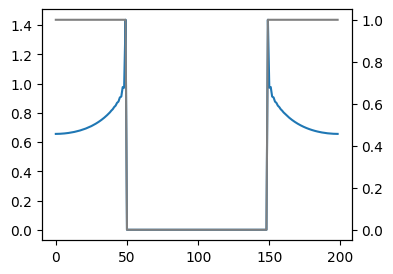

In [18]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
ax.plot(sig.at[:, :, 0, 0].get()[int(N / 2), :] * structure[int(N / 2), :])


ax2 = ax.twinx()
ax2.plot(structure[int(N / 2), :], color="gray")
plt.show()